# Titanic Survivors Classification

## PREPARE DATA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression, SGDClassifier, Perceptron
from sklearn.svm import SVC, LinearSVC 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV, cross_val_score, train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load data
train_test = pd.read_csv('./Dataset/train.csv', index_col='PassengerId')
predict = pd.read_csv('./Dataset/test.csv', index_col='PassengerId')

In [3]:
# Show all nulls in columns
train_test.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [4]:
# Correlation between Pclass and Survived
train_test[["Pclass", "Survived"]].groupby(["Pclass"], as_index=False).mean().sort_values(by="Survived", ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [5]:
# Correlation between Sex and Survived
train_test[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [6]:
# Correlation between SibSp and Survived
train_test[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [7]:
# Correlation between Parch and Survived
train_test[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


In [8]:
# Function to create new column
def substrings_in_string(big_string, substrings):
    for substring in substrings:
        if str.find(big_string, substring) != -1:
            return substring
    return np.nan

In [9]:
# Create new Title column based on Name column
title_list=['Mrs', 'Mr', 'Master', 'Miss', 'Major', 'Rev',
                    'Dr', 'Ms', 'Mlle','Col', 'Capt', 'Mme', 'Countess',
                    'Don', 'Jonkheer']

train_test['Title']=train_test['Name'].map(lambda x: substrings_in_string(x, title_list))
predict['Title']=predict['Name'].map(lambda x: substrings_in_string(x, title_list))

In [10]:
# Replace values in Title column on new values
def replace_titles(x):
    title=x['Title']
    if title in ['Don', 'Major', 'Capt', 'Jonkheer', 'Rev', 'Col']:
        return 'Mr'
    elif title in ['Countess', 'Mme']:
        return 'Mrs'
    elif title in ['Mlle', 'Ms']:
        return 'Miss'
    elif title =='Dr':
        if x['Sex']=='Male':
            return 'Mr'
        else:
            return 'Mrs'
    else:
        return title

train_test['Title']=train_test.apply(replace_titles, axis=1)
predict['Title']=predict.apply(replace_titles, axis=1)

In [11]:
# Create one-hot encode columns instead on numerical values in Title columns
train_test = pd.get_dummies(train_test, columns=['Title'], drop_first=True)
predict = pd.get_dummies(predict, columns=['Title'], drop_first=True)

In [12]:
# Creating new family_size column
train_test['Family_Size']=train_test['SibSp']+train_test['Parch']
predict['Family_Size']=predict['SibSp']+predict['Parch']

In [13]:
# Drop unnecessary columns
train_test.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
predict.drop(['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [14]:
# Change categorical values on numerical values in Sex columns
train_test['Sex'] = train_test['Sex'].map(lambda x: 1 if x == 'male' else 0)
predict['Sex'] = predict['Sex'].map(lambda x: 1 if x == 'male' else 0)

In [15]:
#Drop NaN values in Embarked column
train_test.dropna(subset=['Embarked'], inplace=True)
predict.dropna(subset=['Embarked'], inplace=True)

In [16]:
# Create one-hot encode columns instead on numerical values in Embarked columns
train_test = pd.get_dummies(train_test, columns=['Embarked'], drop_first=True)
predict = pd.get_dummies(predict, columns=['Embarked'], drop_first=True)

In [17]:
# Fill NaN values in Age column in train_test dataset
age_fill = np.zeros((2,3)) 
for s in range(0, 2):
    for p in range(0, 3):
        age_fill_df = train_test[(train_test['Sex'] == s) &\
                           (train_test['Pclass'] == p + 1)]['Age'].dropna()
        age_to_fill = age_fill_df.median()

        # Convert random age float to nearest .5 age
        age_fill[s,p] = int( age_to_fill/0.5 + 0.5 ) * 0.5

for s in range(0, 2):
    for p in range(0, 3):
        train_test.loc[(train_test.Age.isnull()) & (train_test.Sex == s) & (train_test.Pclass == p + 1),\
                'Age'] = age_fill[s,p]

train_test['Age'] = train_test['Age'].astype(int)

In [18]:
# Fill NaN values in Age column in predict dataset
age_fill = np.zeros((2,3)) 
for s in range(0, 2):
    for p in range(0, 3):
        age_fill_df = predict[(predict['Sex'] == s) &\
                           (predict['Pclass'] == p + 1)]['Age'].dropna()
        age_to_fill = age_fill_df.median()

        # Convert random age float to nearest .5 age
        age_fill[s,p] = int( age_to_fill/0.5 + 0.5 ) * 0.5

for s in range(0, 2):
    for p in range(0, 3):
        predict.loc[(predict.Age.isnull()) & (predict.Sex == s) & (predict.Pclass == p + 1),\
                'Age'] = age_fill[s,p]

predict['Age'] = predict['Age'].astype(int)

In [19]:
# Drop NaN values in Fare column
train_test.dropna(subset=['Fare'], inplace=True)
predict.dropna(subset=['Fare'], inplace=True)

# Standardize features by removing the mean and scaling to unit variance in Fare column
min_max = MinMaxScaler()

min_max.fit(train_test['Fare'].values.reshape(-1, 1))
train_test['Fare'] = min_max.transform(train_test['Fare'].values.reshape(-1, 1))
predict['Fare'] = min_max.transform(predict['Fare'].values.reshape(-1, 1))

In [20]:
# Split data on train, test and predict
X_train, X_test, y_train, y_test = train_test_split(train_test.drop('Survived', axis=1), train_test['Survived'], test_size=0.3, random_state=101)
X_pred = predict 

In [21]:
X_train.head()

,Pclass,Sex,Age,Fare,Title_Miss,Title_Mr,Title_Mrs,Family_Size,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
808,3,0,18,0.015176,1,0,0,0,0,1
652,2,0,18,0.044893,1,0,0,1,0,1
3,3,0,26,0.015469,1,0,0,0,0,1
691,1,1,31,0.111257,0,1,0,1,0,1
197,3,1,25,0.015127,0,1,0,0,1,0


## Visualize data

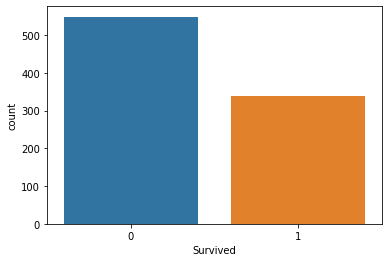

In [22]:
# Survived vs not survived
sns.countplot(data=train_test, x='Survived')

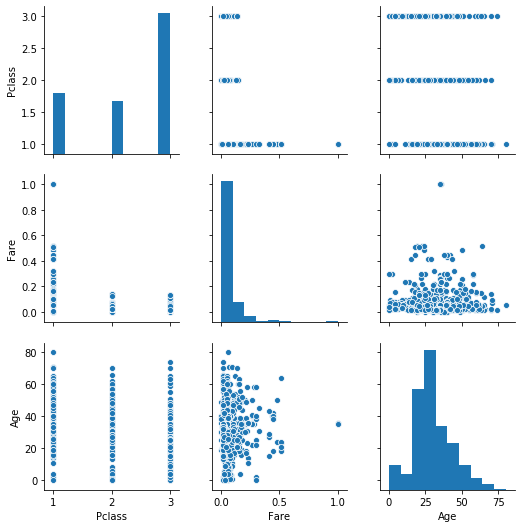

In [23]:
# Correlation between columns
sns.pairplot(data=train_test[['Pclass', 'Fare', 'Age', ]])

## TEST SOME MODELS

### Logistic Regression

In [24]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

lr_train_score = LR.score(X_train, y_train)
lr_test_score = LR.score(X_test, y_test)
lr_pred = LR.predict(X_pred)
print("Train = {:.2f}".format(lr_train_score*100))
print("Test = {:.2f}".format(lr_test_score*100))
print("Predict 10 people:",lr_pred[:10])

Train = 81.51
Test = 84.64
Predict 10 people: [0 1 0 0 1 0 1 0 1 0]


### SVC

In [25]:
svc = SVC()
svc.fit(X_train, y_train)

svc_train_score = svc.score(X_train, y_train)
svc_test_score = svc.score(X_test, y_test)
svc_pred = svc.predict(X_pred)
print("Train = {:.2f}".format(svc_train_score*100))
print("Train = {:.2f}".format(svc_test_score*100))
print("Predict 10 people:",svc_pred[:10])

Train = 83.92
Train = 81.27
Predict 10 people: [0 0 0 0 1 0 1 0 1 0]


### KNeighbors Classifier

In [26]:
KNN = KNeighborsClassifier(n_neighbors = 5)
KNN.fit(X_train, y_train)

kn_train_score = KNN.score(X_train, y_train)
kn_test_score = KNN.score(X_test, y_test)
knn_pred = KNN.predict(X_pred)
print("Train = {:.2f}".format(kn_train_score*100))
print("Test = {:.2f}".format(kn_test_score*100))
print("Predict 10 people:",knn_pred[:10])

Train = 83.92
Test = 79.78
Predict 10 people: [0 0 0 0 1 0 0 0 0 0]


### GaussianNB

In [27]:
GNB = GaussianNB()
GNB.fit(X_train, y_train)

gnb_train_score = GNB.score(X_train, y_train)
gnb_test_score = GNB.score(X_test, y_test)
gnb_pred = GNB.predict(X_pred)
print("Train = {:.2f}".format(gnb_train_score*100))
print("Test = {:.2f}".format(gnb_test_score*100))
print("Predict 10 people:",gnb_pred[:10])

Train = 77.97
Test = 79.78
Predict 10 people: [0 1 0 0 1 0 1 0 1 0]


### Linear SVC

In [28]:
LSVC = LinearSVC()
LSVC.fit(X_train, y_train)

lsvc_train_score = LSVC.score(X_train, y_train)
lsvc_test_score = LSVC.score(X_test, y_test)
lsvc_pred = LSVC.predict(X_pred)
print("Train = {:.2f}".format(lsvc_train_score*100))
print("Test = {:.2f}".format(lsvc_test_score*100))
print("Predict 10 people:",lsvc_pred[:10])

Train = 83.12
Test = 85.39
Predict 10 people: [0 0 0 0 1 0 1 0 1 0]


### Perceptron

In [29]:
perceptron = Perceptron()
perceptron.fit(X_train, y_train)

per_train_score = perceptron.score(X_train, y_train)
per_test_score = perceptron.score(X_test, y_test)
per_pred = perceptron.predict(X_pred)
print("Train = {:.2f}".format(per_train_score*100))
print("Test = {:.2f}".format(per_test_score*100))
print("Predict 10 people:",per_pred[:10])

Train = 82.15
Test = 82.02
Predict 10 people: [0 0 0 0 1 0 0 0 1 0]


### SGD Classifier

In [30]:
SGD = SGDClassifier()
SGD.fit(X_train, y_train)

sgd_train_score = SGD.score(X_train, y_train)
sgd_test_score = SGD.score(X_test, y_test)
sgd_pred = SGD.predict(X_pred)
print("Train = {:.2f}".format(sgd_train_score*100))
print("Test = {:.2f}".format(sgd_test_score*100))
print("Predict 10 people:",sgd_pred[:10])

Train = 76.37
Test = 75.66
Predict 10 people: [0 0 0 0 0 0 0 0 1 0]


### Decision Tree Classifier

In [31]:
DT = DecisionTreeClassifier(max_depth=None, max_features=None, min_samples_leaf=1, random_state=42)
DT.fit(X_train, y_train)

dt_train_score = DT.score(X_train, y_train)
dt_test_score = DT.score(X_test, y_test)
dt_pred = DT.predict(X_pred)
print("Train = {:.2f}".format(dt_train_score*100))
print("Test = {:.2f}".format(dt_test_score*100))
print("Predict 10 people:",dt_pred[:10])

Train = 98.71
Test = 79.40
Predict 10 people: [0 0 1 0 0 0 0 0 1 0]


### Random Forest Regressor

In [32]:
RF = RandomForestRegressor(n_estimators = 100)
RF.fit(X_train, y_train)

rf_train_score = RF.score(X_train, y_train)
rf_test_score = RF.score(X_test, y_test)
rf_pred = RF.predict(X_pred)
print("Train = {:.2f}".format(rf_train_score*100))
print("Test = {:.2f}".format(rf_test_score*100))
print("Predict probability of survival for 10 passenger:",rf_pred[:10])

Train = 89.37
Test = 43.33
Predict probability of survival for 10 passenger: [0.20285714 0.12       0.58       0.15       0.65       0.075
 0.23366667 0.06       0.93       0.02      ]


## Predictive models

In [33]:
Predictive_models = pd.DataFrame({
    'Model': ['SVC', 'KNN', 'LR', 'RF', 'GNB', 
              'Perceptron','SGD', 'LSVC', 'DT'],
    'Score-train': [svc_train_score, kn_train_score, lr_train_score, rf_train_score, gnb_train_score, 
              per_train_score, sgd_train_score, lsvc_train_score, dt_train_score],
    'Score-test': [svc_test_score, kn_test_score, lr_test_score, rf_test_score, gnb_test_score, 
              per_test_score, sgd_test_score, lsvc_test_score, dt_test_score]})
Predictive_models.sort_values(by ='Score-test', ascending=False)

,Model,Score-train,Score-test
7,LSVC,0.831190,0.853933
2,LR,0.815113,0.846442
5,Perceptron,0.821543,0.820225
0,SVC,0.839228,0.812734
1,KNN,0.839228,0.797753
4,GNB,0.779743,0.797753
8,DT,0.987138,0.794007
6,SGD,0.763666,0.756554
3,RF,0.893698,0.433335


## Cross validation

In [34]:
LR = LogisticRegression()

kfold = KFold(n_splits = 10, shuffle = True, random_state = 0)
kfold_score = cross_val_score(LR, X_train, y_train, cv = kfold)

kfold_score_mean = np.mean(kfold_score)
  
print("LogisticRegression accuracy score per fold : ", kfold_score, "\n")
print("Average accuracy score : {:.4f}".format(kfold_score_mean))

LogisticRegression accuracy score per fold :  [0.79365079 0.85714286 0.83870968 0.80645161 0.77419355 0.87096774
 0.85483871 0.72580645 0.83870968 0.70967742] 

Average accuracy score : 0.8070


## Parameter tuning

In [35]:
LR = LogisticRegression()

parameters = {'penalty': ['l2'],
             'C' : [0.001,0.01,0.1,1,10,100,1000],
             'random_state': [0, 25, 75, 125, 250],
             'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']}
clf = GridSearchCV(LR, parameters)
clf.fit(X_train, y_train)

LR_Model = clf.best_estimator_
print('BEST SCORE AND PARAMS:', clf.best_score_, clf.best_params_)
print('BEST MODEL:', LR_Model)

lr_best_score = LR_Model.score(X_test, y_test)
print('Test result', lr_best_score)
lr_predict = LR_Model.predict(X_pred[:10])
print("Predict 10 people:",lr_predict)

BEST SCORE AND PARAMS: 0.819935691318328 {'C': 1, 'penalty': 'l2', 'random_state': 0, 'solver': 'lbfgs'}
BEST MODEL: LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Test result 0.850187265917603
Predict 10 people: [0 0 0 0 1 0 1 0 1 0]
